In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
import numpy as np
import math
from typing import Tuple

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import matplotlib.pyplot as plt   
import seaborn as sns
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])

from tqdm.auto import tqdm

import io
from PIL import Image
import IPython.display as disp

In [2]:
device               = params.device
ticker               = params.ticker
save_path            = params.save_path
pred_threshold       = params.pred_threshold_tick
trailing_stop_pred   = params.trailing_stop_pred_tick
look_back            = params.look_back_tick


In [3]:
df_feat = pd.read_csv(params.feat_csv, index_col=0, parse_dates=True)
df_feat

vol_15  bb_width_20  hour       ma_20  macd_signal_9  \
2004-01-02 12:49:00  0.000000     0.000000    12    0.764286       0.000000   
2004-01-02 12:50:00  0.000000     0.000000    12    0.764286       0.000000   
2004-01-02 12:51:00  0.000000     0.000000    12    0.764286       0.000000   
2004-01-02 12:52:00  0.000000     0.000000    12    0.764286       0.000000   
2004-01-02 12:53:00  0.000000     0.000000    12    0.764286       0.000000   
...                       ...          ...   ...         ...            ...   
2025-06-18 20:56:00  0.000804     0.004172    20  196.325795       0.134526   
2025-06-18 20:57:00  0.000836     0.004427    20  196.348545       0.143513   
2025-06-18 20:58:00  0.000823     0.004636    20  196.369045       0.150810   
2025-06-18 20:59:00  0.001017     0.004652    20  196.367545       0.149460   
2025-06-18 21:00:00  0.001078     0.004619    21  196.385795       0.147207   

                            low    atr_14           obv  vwap_dev  \
2004-01-02 12:49:00    0.764286  0.000000  0.000000e+00  0.000000   
2004-01-02 12:50:00    0.764286  0.000000  0.000000e+00  0.000000   
2004-01-02 12:51:00    0.764286  0.000000  0.000000e+00  0.000000   
2004-01-02 12:52:00    0.764286  0.000000  0.000000e+00  0.000000   
2004-01-02 12:53:00    0.764286  0.000000  0.000000e+00  0.000000   
...                         ...       ...           ...       ...   
2025-06-18 20:56:00  196.630000  0.276029  1.861149e+10  9.692697   
2025-06-18 20:57:00  196.560000  0.291029  1.861103e+10  9.685066   
2025-06-18 20:58:00  196.630000  0.291743  1.861051e+10  9.684766   
2025-06-18 20:59:00  196.240000  0.313971  1.860843e+10  9.661294   
2025-06-18 21:00:00  196.080000  0.344693  1.862403e+10  9.676753   

                     volume_spike      r_15       close        ma_5  \
2004-01-02 12:49:00      1.000000  0.000000    0.764286    0.764286   
2004-01-02 12:50:00      1.000000  0.000000    0.764286    0.764286   
2004-01-02 12:51:00      1.000000  0.000000    0.764286    0.764286   
2004-01-02 12:52:00      1.000000  0.000000    0.764286    0.764286   
2004-01-02 12:53:00      1.000000  0.000000    0.764286    0.764286   
...                           ...       ...         ...         ...   
2025-06-18 20:56:00      1.703441  0.003639  196.815000  196.593000   
2025-06-18 20:57:00      1.841981  0.003081  196.675000  196.650000   
2025-06-18 20:58:00      1.883214  0.002291  196.670000  196.672000   
2025-06-18 20:59:00      5.053932 -0.000255  196.240000  196.618000   
2025-06-18 21:00:00     10.811366  0.001833  196.540000  196.588000   

                           open        high         bid         ask    signal  
2004-01-02 12:49:00    0.764286    0.764286    0.764057    0.764514  0.028956  
2004-01-02 12:50:00    0.764286    0.764286    0.764057    0.764514  0.029218  
2004-01-02 12:51:00    0.764286    0.764286    0.764057    0.764514  0.029482  
2004-01-02 12:52:00    0.764286    0.764286    0.764057    0.764514  0.029749  
2004-01-02 12:53:00    0.764286    0.764286    0.764057    0.764514  0.030018  
...                         ...         ...         ...         ...       ...  
2025-06-18 20:56:00  196.680000  196.860000  196.756000  196.874000  0.000000  
2025-06-18 20:57:00  196.810000  196.940000  196.616000  196.734000  0.000000  
2025-06-18 20:58:00  196.675000  196.740000  196.611000  196.729000  0.000000  
2025-06-18 20:59:00  196.680000  196.750000  196.181100  196.298900  0.000000  
2025-06-18 21:00:00  196.580000  196.650000  196.481000  196.599000  0.000000  

[2756826 rows x 18 columns]

{'ATT_DROPOUT': 0.1,
 'ATT_HEADS': 8,
 'CLIPNORM': 1,
 'DROPOUT_LONG': 0.15,
 'DROPOUT_SHORT': 0.1,
 'EARLY_STOP_PATIENCE': 12,
 'ETA_MIN': 5e-05,
 'INITIAL_LR': 0.05,
 'LONG_UNITS': 128,
 'LR_EPOCHS_WARMUP': 1,
 'MAX_EPOCHS': 60,
 'MIN_LR': 1e-06,
 'NUM_WORKERS': 2,
 'PLATEAU_FACTOR': 0.9,
 'PLATEAU_PATIENCE': 0,
 'PLAT_EPOCHS_WARMUP': 999,
 'SHORT_UNITS': 96,
 'TRAIN_BATCH': 32,
 'TRAIN_PREFETCH_FACTOR': 1,
 'T_0': 60,
 'T_MULT': 1,
 'VAL_BATCH': 1,
 'WEIGHT_DECAY': 1e-06}


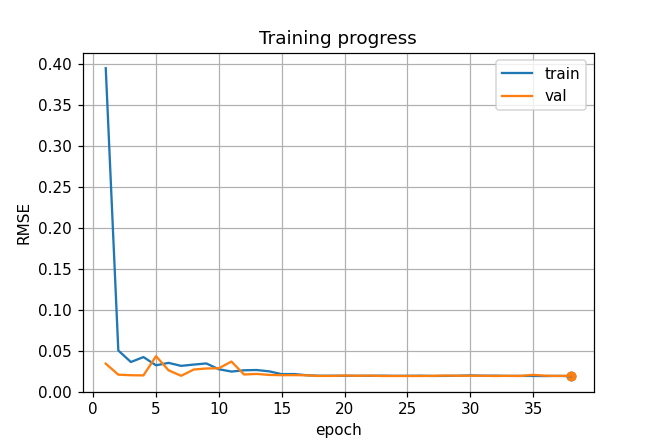

DualMemoryLSTM(
  (short_lstm): LSTM(15, 96, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
  )
  (do_short): Dropout(p=0.28062499272843455, inplace=False)
  (ln_short): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(96, 128, batch_first=True)
  (do_long): Dropout(p=0.000847939960876988, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
)

In [4]:
# Load the entire model object (architecture + weights)# 1) load your checkpoint dict
ckpt = torch.load(params.model_path, map_location=device, weights_only=False)

# 2) grab the full model object you saved
model_best = ckpt["model_obj"]

# 3) move to device and set eval mode
model_best = model_best.to(device).eval()

# 4) show parameters, training plot, and model
saved_hparams = ckpt["hparams"]
pprint(saved_hparams)

png_bytes = ckpt.get("train_plot_png")
img = Image.open(io.BytesIO(png_bytes))
disp.display(img)

model_best


In [5]:
print('executing <build_lstm_tensors>...')
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df=df_feat,
    look_back=look_back,
    features_cols=params.features_cols_tick,
    label_col=params.label_col,
    regular_start=params.regular_start_pred 
)

print('executing <chronological_split>...')
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df_feat,
    look_back    = look_back,
    regular_start=params.regular_start_pred, 
    train_prop   = params.train_prop,
    val_prop     = params.val_prop,
    train_batch  = params.hparams['TRAIN_BATCH']
)

print('executing <split_to_day_datasets>...')
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df_feat,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS']
)

print('dataloaders generated!')

executing <build_lstm_tensors>...
executing <chronological_split>...
executing <split_to_day_datasets>...
▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=1702957, val=365310, te=364859
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..809], total days=810
   te_day_id  ∈ [0..808], total days=809
4) instantiating DayWindowDatasets
   ds_tr days: 3776
   ds_val days: 810
   ds_te days: 809
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready
dataloaders generated!


In [6]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(val_loader)
test_baseline = models.naive_rmse(test_loader)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.02091
Test zero‐forecast baseline RMSE = 0.02729


std val: 0.019696316
std test: 0.026474288


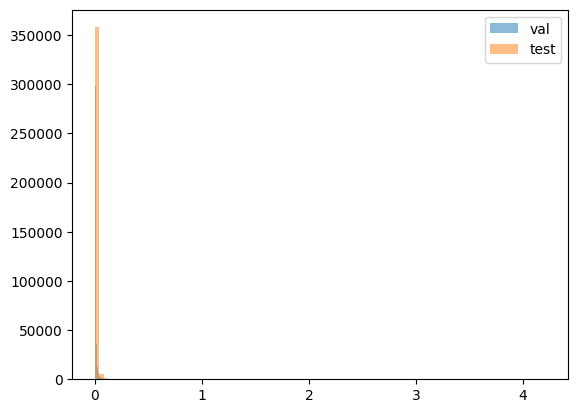

In [7]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in val_loader])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in test_loader])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

In [8]:
def evaluate_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    split_name: str
) -> Tuple[float, np.ndarray]:
    """
    Fast per-day RMSE + preds, exactly matching  val‐phase logic:

    • Expects each batch from `loader` to be a tuple of at least
      (xb_batch, yb_batch, day_id_batch, …). We only use the first 3.
    • xb_batch: Tensor(B, W, look_back, F)
    • yb_batch: Tensor(B, W)
    • day_id_batch: Tensor(B,) or (B, W) weekday/day‐id
    """

    model.to(device).eval()
    model.h_short = model.h_long = None

    prev_day_id   = None
    total_sq_err  = 0.0
    total_windows = 0
    all_preds     = []

    with torch.no_grad():
        for batch in tqdm(loader, desc=split_name, unit="batch"):
            # grab only the first three outputs, ignore raw_close/raw_bid/etc.
            xb_batch, yb_batch, day_id_batch = batch[:3]

            # move to device once
            xb_batch     = xb_batch.to(device, non_blocking=True)
            yb_batch     = yb_batch.to(device, non_blocking=True)
            day_id_batch = day_id_batch.to(device, non_blocking=True)

            # if we got one day_id per window, reduce to one/day
            if day_id_batch.dim() > 1:
                day_id_batch = day_id_batch[:, 0]

            B, W = xb_batch.shape[0], xb_batch.shape[1]

            for i in range(B):
                x_day  = xb_batch[i]             # (W, look_back, F)
                y_day  = yb_batch[i].view(-1)    # (W,)
                day_id = int(day_id_batch[i].item())

                # reset LSTM states exactly as in val loop
                model.reset_short()
                if prev_day_id is not None and day_id < prev_day_id:
                    model.reset_long()
                prev_day_id = day_id

                out      = model(x_day)          # (W, look_back, 1)
                pred_day = out[:, -1, 0]         # (W,)

                total_sq_err  += (pred_day - y_day).pow(2).sum().item()
                total_windows += y_day.numel()
                all_preds.append(pred_day.cpu().numpy())

    rmse  = math.sqrt(total_sq_err / total_windows)
    preds = np.concatenate(all_preds, axis=0)

    print(f"\n{split_name} RMSE over {total_windows} windows = {rmse:.5f}")
    return rmse, preds


In [9]:
# train_rmse, train_preds = evaluate_model(
#     model_best, train_loader, device,
#     split_name="Train"
# )
val_rmse, val_preds     = evaluate_model(
    model_best, val_loader,   device,
    split_name="Validation"
)
test_rmse, test_preds   = evaluate_model(
    model_best, test_loader,  device,
    split_name="Test"
)

# print("Train preds:", len(train_preds))
print("Val   preds:", len(val_preds))
print("Test  preds:", len(test_preds))

Validation:   0%|          | 0/810 [00:00<?, ?batch/s]


Validation RMSE over 365310 windows = 0.01938


Test:   0%|          | 0/809 [00:00<?, ?batch/s]


Test RMSE over 364859 windows = 0.02609
Val   preds: 365310
Test  preds: 364859


In [10]:
def add_pred_actions(
    df: pd.DataFrame,
    preds: np.ndarray,
    day_id_te: np.ndarray
) -> pd.DataFrame:
    """
    Returns a full-day DataFrame augmented with
      - pred_signal (NaN outside test-window)
      - pred_action (integer: -1/0/+1 everywhere)
    so downstream sim & plotting see the full x-axis.
    """
    # 1) Copy & init columns
    df_pred = df.copy()
    df_pred["pred_signal"] = np.nan
    df_pred["pred_action"] = 0  # default: no trade

    # 2) Identify test‐days by index normalize & map via day_id_te
    all_days = sorted(df_pred.index.normalize().unique())
    test_ids = np.unique(day_id_te).astype(int)
    test_days = [all_days[i] for i in test_ids]

    # 3) Build mask of all post-start rows on test days
    mask = (
        df_pred.index.normalize().isin(test_days)
        & (df_pred.index.time >= params.regular_start_pred) 
    )
    idx = df_pred.loc[mask].index

    # 4) Stamp your model’s predictions on those valid slots
    if len(idx) != len(preds):
        raise ValueError(
            f"Expected {len(idx)} prediction slots, got {len(preds)} preds"
        )
    df_pred.loc[idx, "pred_signal"] = preds

    # 5) Generate & write back integer actions per test day
    for day in test_days:
        # slice just that day
        day_slice = df_pred[df_pred.index.normalize() == day]

        # generate_trade_actions expects pred_signal + writes pred_action
        day_actions = trades.generate_trade_actions(
            df                   = day_slice,
            col_signal           = "pred_signal",
            col_action           = "pred_action",
            buy_threshold        = pred_threshold,
            trailing_stop_thresh = trailing_stop_pred,
            regular_start        = params.regular_start
        )

        # overwrite int actions only on real trade timestamps
        df_pred.loc[day_actions.index, "pred_action"] = (
            day_actions["pred_action"]
            .fillna(0)
            .astype(int)
        )

    # 6) Save & split back out
    df_pred.to_csv(params.pred_csv)

    return df_pred.loc[idx]


In [11]:
df_pred = add_pred_actions(
                        df=df_feat, 
                        preds=test_preds, 
                        day_id_te=day_id_te
                        )

df_pred

vol_15  bb_width_20  hour       ma_20  macd_signal_9  \
2022-03-29 13:30:00  0.000508     0.006482    13  176.535000       0.134459   
2022-03-29 13:31:00  0.000496     0.006605    13  176.561500       0.142162   
2022-03-29 13:32:00  0.000497     0.006681    13  176.588500       0.147684   
2022-03-29 13:33:00  0.000504     0.006394    13  176.621500       0.150415   
2022-03-29 13:34:00  0.000504     0.006142    13  176.654500       0.151709   
...                       ...          ...   ...         ...            ...   
2025-06-18 20:56:00  0.000804     0.004172    20  196.325795       0.134526   
2025-06-18 20:57:00  0.000836     0.004427    20  196.348545       0.143513   
2025-06-18 20:58:00  0.000823     0.004636    20  196.369045       0.150810   
2025-06-18 20:59:00  0.001017     0.004652    20  196.367545       0.149460   
2025-06-18 21:00:00  0.001078     0.004619    21  196.385795       0.147207   

                         low    atr_14           obv   vwap_dev  volume_spike  \
2022-03-29 13:30:00  176.830  0.130714  1.902651e+10  11.703991      0.875532   
2022-03-29 13:31:00  176.870  0.120000  1.902651e+10  11.702554      0.164882   
2022-03-29 13:32:00  176.801  0.117071  1.902651e+10  11.703272      0.573779   
2022-03-29 13:33:00  176.820  0.120643  1.902651e+10  11.699680      0.457595   
2022-03-29 13:34:00  176.750  0.111357  1.902652e+10  11.703271      0.672491   
...                      ...       ...           ...        ...           ...   
2025-06-18 20:56:00  196.630  0.276029  1.861149e+10   9.692697      1.703441   
2025-06-18 20:57:00  196.560  0.291029  1.861103e+10   9.685066      1.841981   
2025-06-18 20:58:00  196.630  0.291743  1.861051e+10   9.684766      1.883214   
2025-06-18 20:59:00  196.240  0.313971  1.860843e+10   9.661294      5.053932   
2025-06-18 21:00:00  196.080  0.344693  1.862403e+10   9.676753     10.811366   

                         r_15    close     ma_5     open    high       bid  \
2022-03-29 13:30:00  0.004192  176.890  176.912  176.900  176.90  176.8369   
2022-03-29 13:31:00  0.003285  176.870  176.896  176.890  176.90  176.8169   
2022-03-29 13:32:00  0.003228  176.880  176.890  176.830  176.88  176.8269   
2022-03-29 13:33:00  0.003115  176.830  176.880  176.860  176.89  176.7770   
2022-03-29 13:34:00  0.003284  176.880  176.870  176.800  176.88  176.8269   
...                       ...      ...      ...      ...     ...       ...   
2025-06-18 20:56:00  0.003639  196.815  196.593  196.680  196.86  196.7560   
2025-06-18 20:57:00  0.003081  196.675  196.650  196.810  196.94  196.6160   
2025-06-18 20:58:00  0.002291  196.670  196.672  196.675  196.74  196.6110   
2025-06-18 20:59:00 -0.000255  196.240  196.618  196.680  196.75  196.1811   
2025-06-18 21:00:00  0.001833  196.540  196.588  196.580  196.65  196.4810   

                          ask    signal  pred_signal  pred_action  
2022-03-29 13:30:00  176.9431  0.004755     0.007083            0  
2022-03-29 13:31:00  176.9231  0.004878     0.006748            0  
2022-03-29 13:32:00  176.9331  0.004882     0.006488            0  
2022-03-29 13:33:00  176.8830  0.005128     0.006386            0  
2022-03-29 13:34:00  176.9331  0.004971     0.006268            0  
...                       ...       ...          ...          ...  
2025-06-18 20:56:00  196.8740  0.000000     0.003148            0  
2025-06-18 20:57:00  196.7340  0.000000     0.003248            0  
2025-06-18 20:58:00  196.7290  0.000000     0.003334            0  
2025-06-18 20:59:00  196.2989  0.000000     0.003230            0  
2025-06-18 21:00:00  196.5990  0.000000     0.003143            0  

[364859 rows x 20 columns]

In [12]:
# Compute Descriptive Statistics
# Statistics show whether your model systematically over/under-estimates (compare means) and how tightly it tracks (std & correlation).

# assume df is your DataFrame
stats = df_pred[['signal','pred_signal']].describe().T

# add range and error
stats['range'] = stats['max'] - stats['min']
corr = df_pred['signal'].corr(df_pred['pred_signal'])
stats['pearson_r_with_other'] = [corr, corr]

stats

count      mean       std       min       25%       50%  \
signal       364859.0  0.006619  0.026474  0.000000  0.000576  0.002209   
pred_signal  364859.0  0.003582  0.002540  0.002293  0.002562  0.002705   

                  75%       max     range  pearson_r_with_other  
signal       0.006208  4.213931  4.213931              0.266555  
pred_signal  0.003281  0.058776  0.056483              0.266555

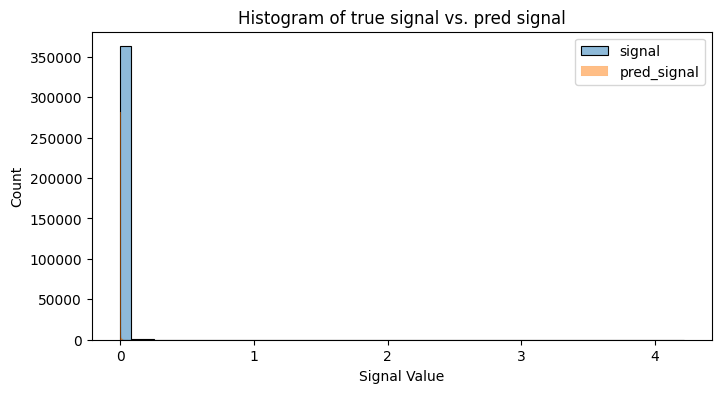

In [13]:
# Distribution Overlay
# Histogram overlay reveals any bias or mismatched shape in the two distributions.

plt.figure(figsize=(8,4))
sns.histplot(df_pred['signal'], color='C0', alpha=0.5, bins=50, label='signal')
sns.histplot(df_pred['pred_signal'],   color='C1', alpha=0.5, bins=50, label='pred_signal')
plt.legend()
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.title('Histogram of true signal vs. pred signal')
plt.show()

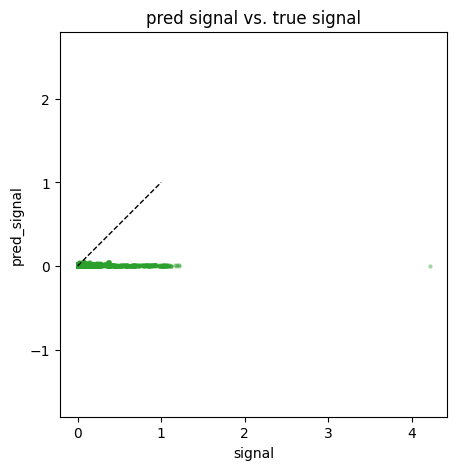

In [14]:
# Scatter Plot: Relationship
# Scatter against the 45° line instantly shows under/over‐prediction regions and non‐linear errors.

plt.figure(figsize=(5,5))
plt.scatter(df_pred['signal'], df_pred['pred_signal'],
            s=5, alpha=0.3, color='C2')
plt.plot([0,1],[0,1], 'k--', linewidth=1)  # 45° reference line
plt.xlabel('signal')
plt.ylabel('pred_signal')
plt.title('pred signal vs. true signal')
plt.axis('equal')
plt.show()

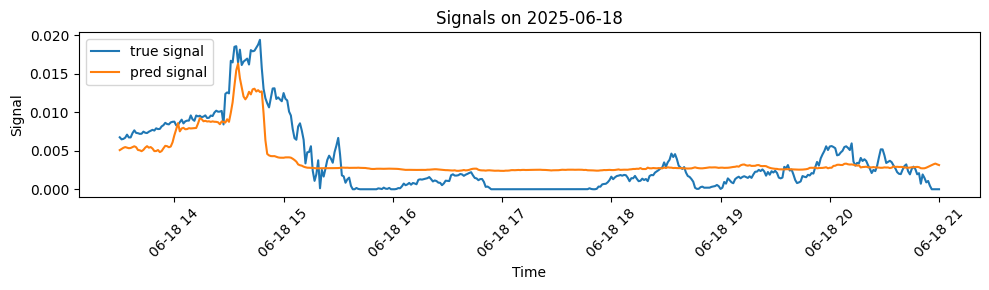

In [15]:
# Time-Series Comparison (Sample)
# Time‐series plots let you see if the model lags or leads the smoothed signal on a given day.

# pick a single day or time span
day = df_pred.index.normalize().unique()[-1]
mask = df_pred.index.normalize() == day

plt.figure(figsize=(10,3))
plt.plot(df_pred.index[mask], df_pred.loc[mask,'signal'], label='true signal')
plt.plot(df_pred.index[mask], df_pred.loc[mask,'pred_signal'],   label='pred signal')
plt.legend(loc='upper left')
plt.title(f'Signals on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

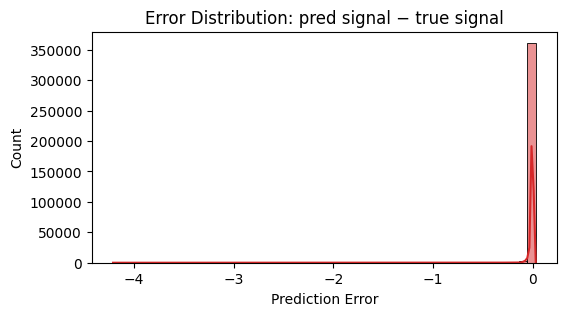

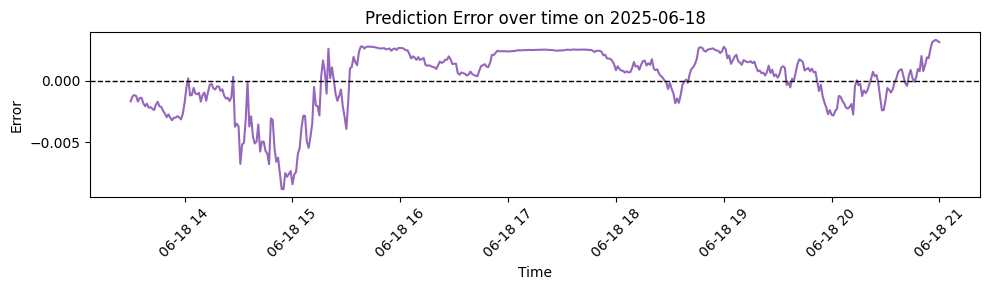

In [16]:
# Error Analysis 
# Error plots quantify where and when the model struggles most, guiding you to fix lag, amplitude scaling, or threshold issues.

# create error column
df_pred['error'] = df_pred['pred_signal'] - df_df_predtest['signal']

# Distribution of prediction error
plt.figure(figsize=(6,3))
sns.histplot(df_pred['error'], bins=50, color='C3', kde=True)
plt.xlabel('Prediction Error')
plt.title('Error Distribution: pred signal − true signal')
plt.show()

# Time evolution of error on that same sample day
plt.figure(figsize=(10,3))
plt.plot(df_pred.index[mask], df_pred.loc[mask,'error'], color='C4')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Prediction Error over time on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
print('generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...')

# Run the simulator on your DataFrame of predictions/actions
sim_results = trades.simulate_trading(
    results_by_day_sign = df_pred,              # DF with pred_action
    col_action          = "pred_action",        # name of the discrete action column
    regular_start       = params.regular_start,   
    regular_end         = params.regular_end,         
    ticker              = params.ticker
)


generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...



Plotting days in 2022-04:


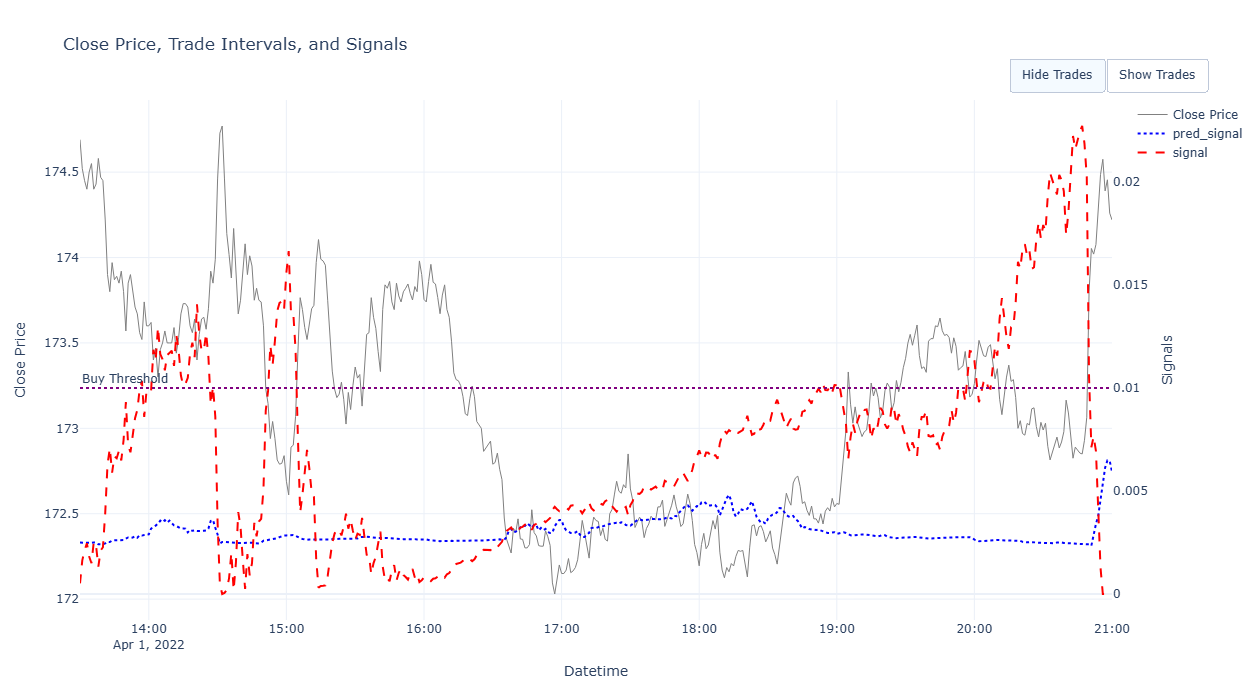


=== Performance for 2022-04-01 00:00:00 ===
Buy & Hold Return ($): -0.345
Strategy Return ($): 0.0
Trades Returns ($): []


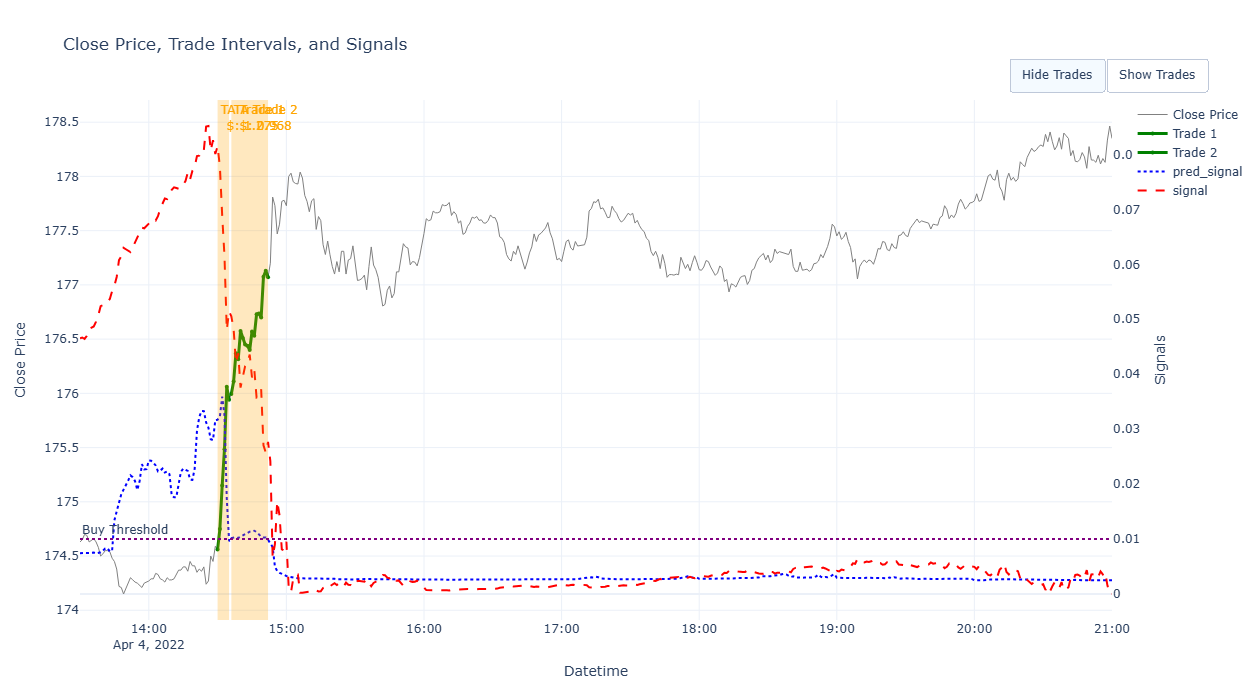


=== Performance for 2022-04-04 00:00:00 ===
Buy & Hold Return ($): 3.684
Strategy Return ($): 2.244
Trades Returns ($): [1.275, 0.968]


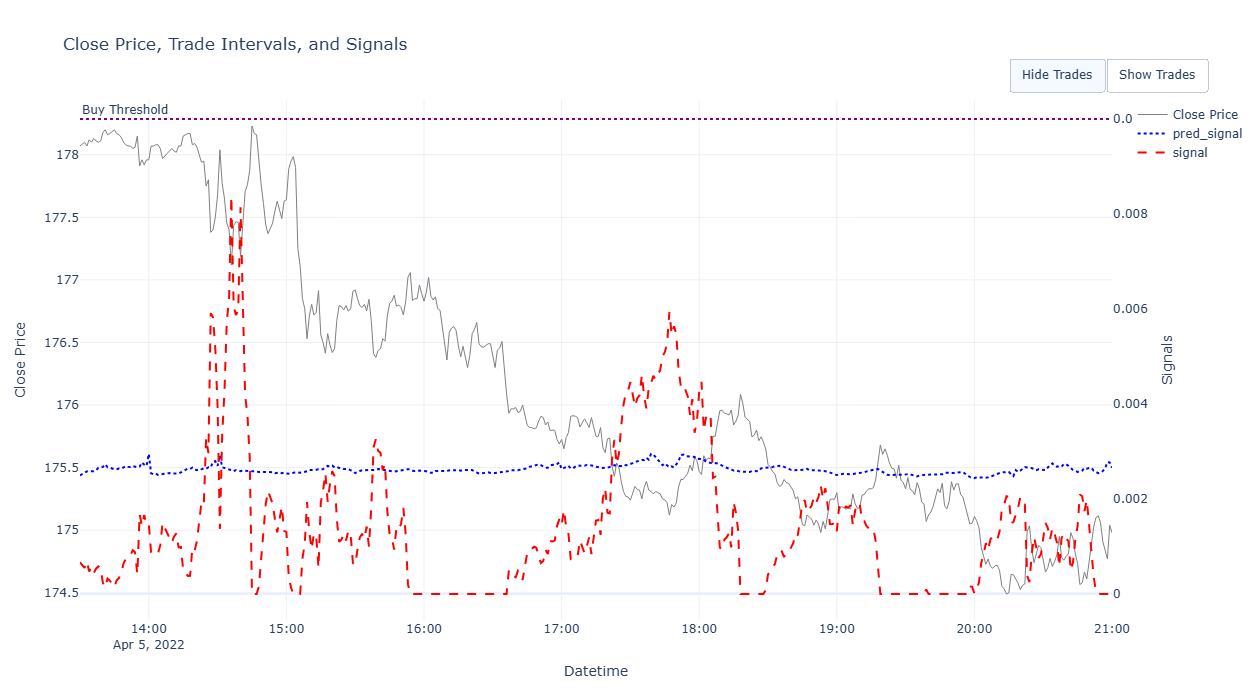


=== Performance for 2022-04-05 00:00:00 ===
Buy & Hold Return ($): -2.806
Strategy Return ($): 0.0
Trades Returns ($): []


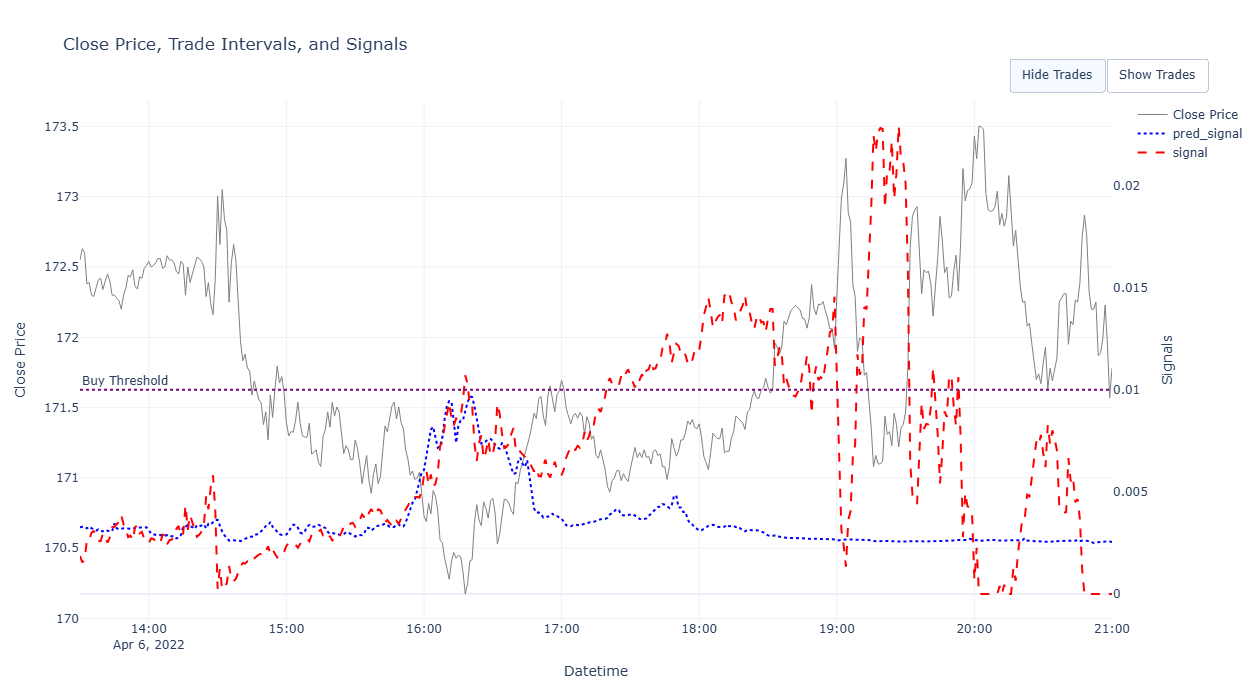


=== Performance for 2022-04-06 00:00:00 ===
Buy & Hold Return ($): -1.328
Strategy Return ($): 0.0
Trades Returns ($): []


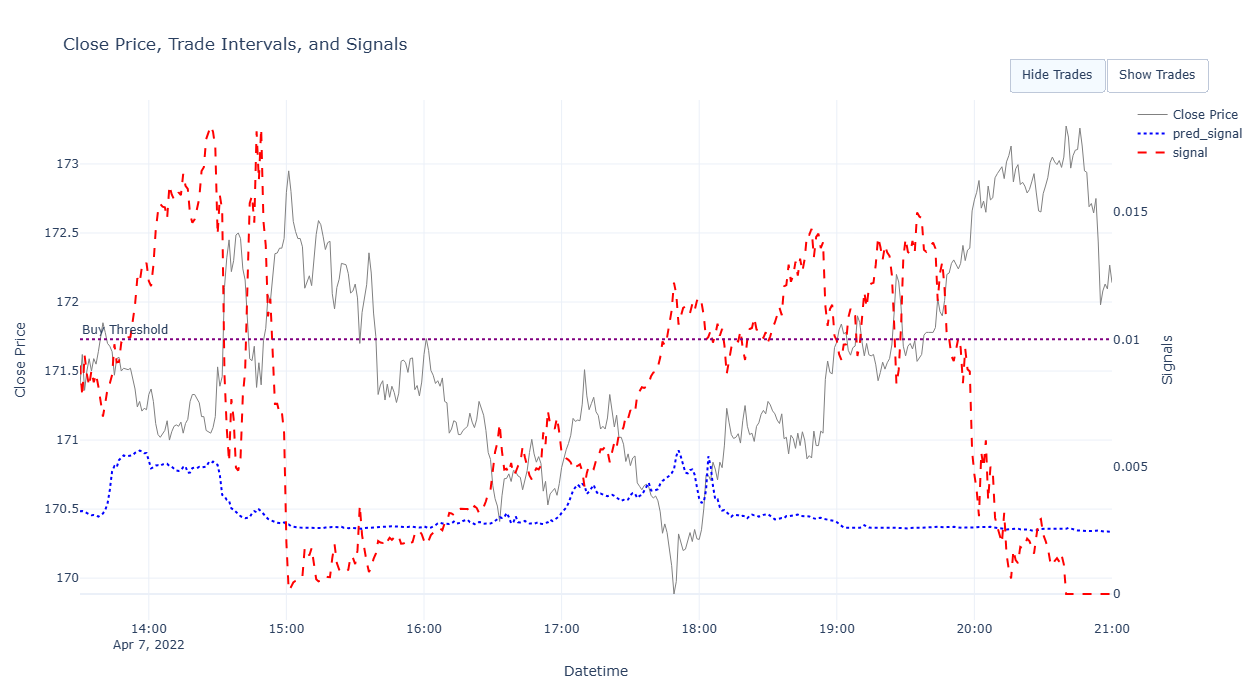


=== Performance for 2022-04-07 00:00:00 ===
Buy & Hold Return ($): 0.507
Strategy Return ($): 0.0
Trades Returns ($): []


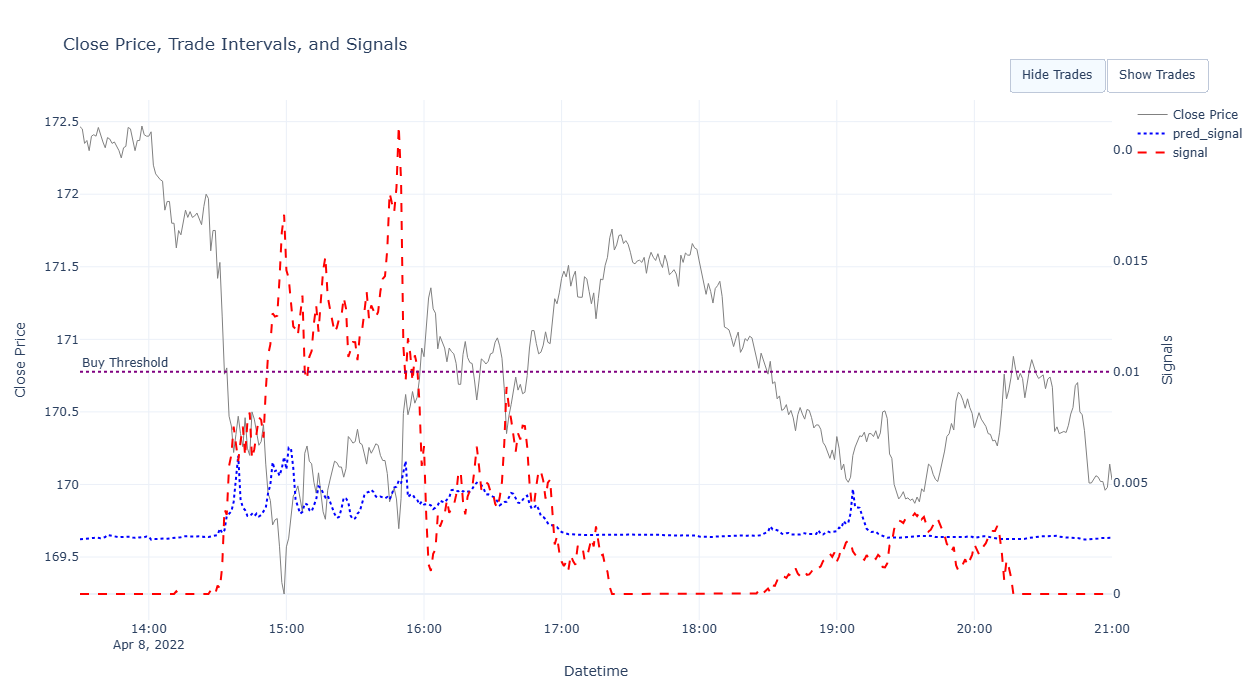


=== Performance for 2022-04-08 00:00:00 ===
Buy & Hold Return ($): -1.492
Strategy Return ($): 0.0
Trades Returns ($): []


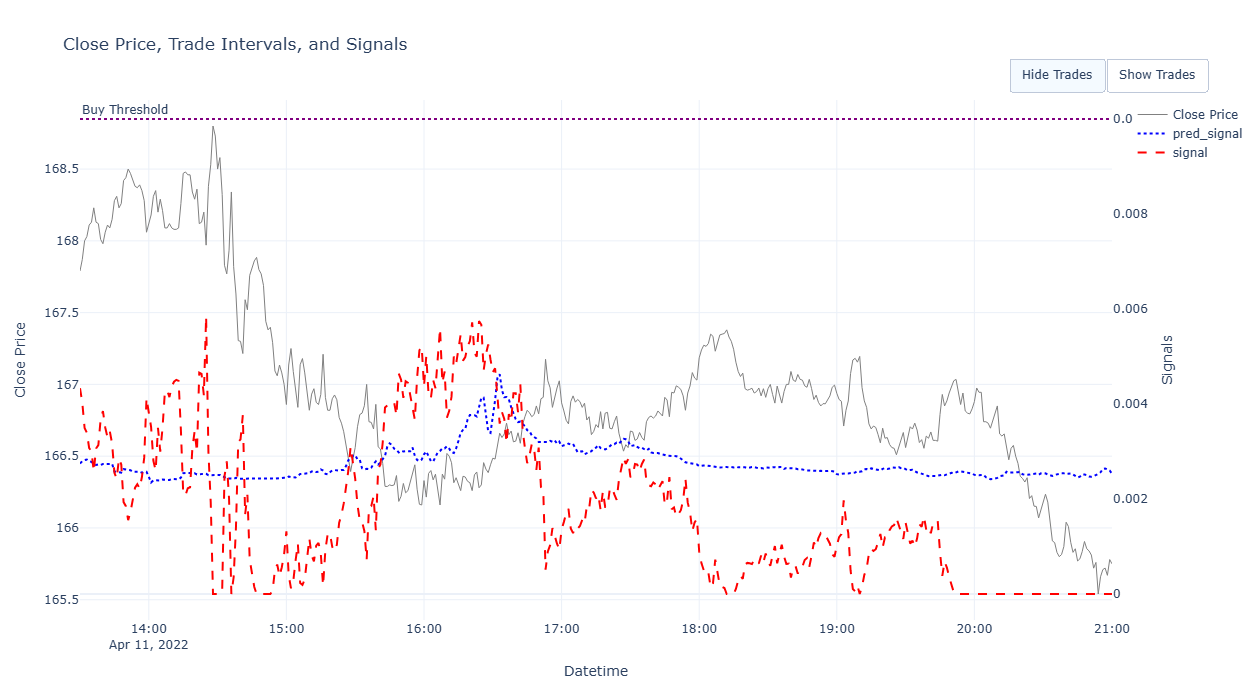


=== Performance for 2022-04-11 00:00:00 ===
Buy & Hold Return ($): -2.85
Strategy Return ($): 0.0
Trades Returns ($): []


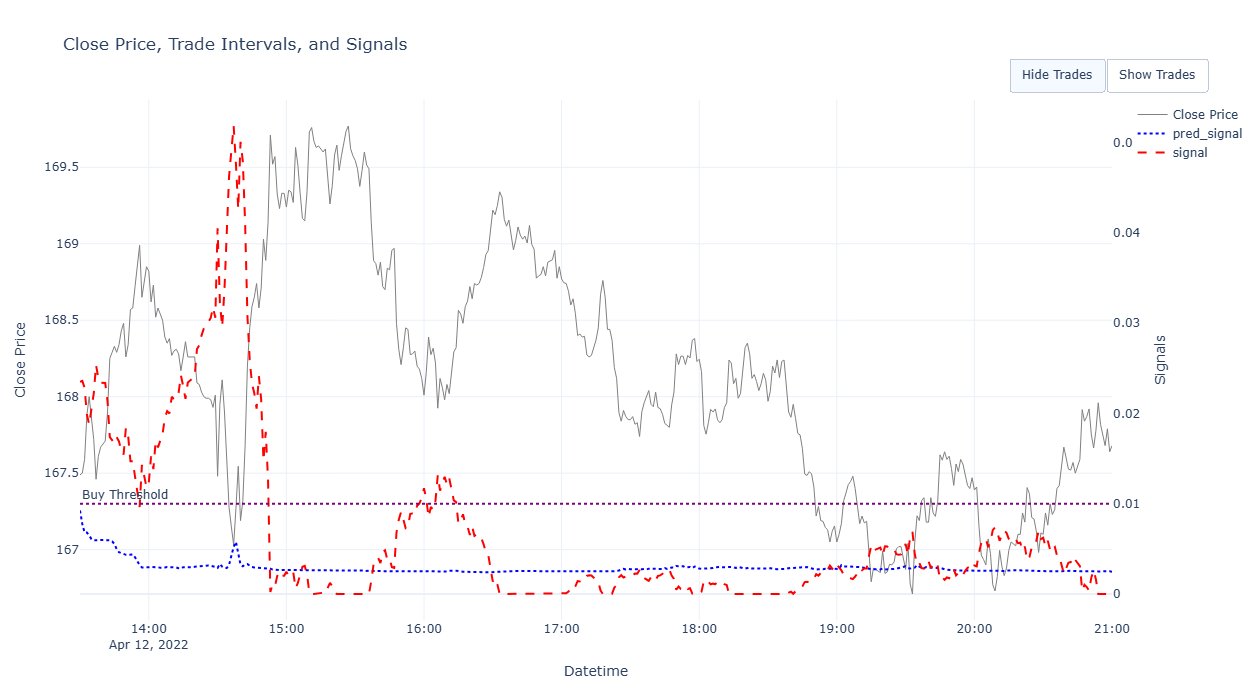


=== Performance for 2022-04-12 00:00:00 ===
Buy & Hold Return ($): 0.1
Strategy Return ($): 0.0
Trades Returns ($): []


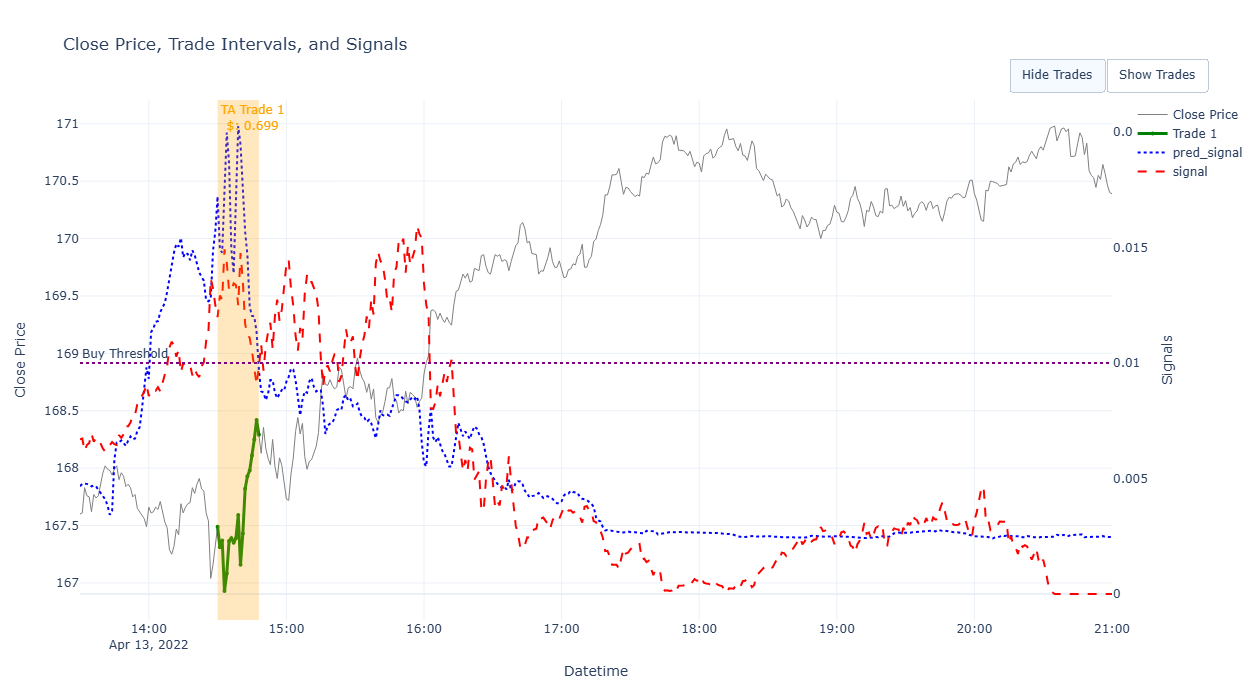


=== Performance for 2022-04-13 00:00:00 ===
Buy & Hold Return ($): 2.799
Strategy Return ($): 0.699
Trades Returns ($): [0.699]


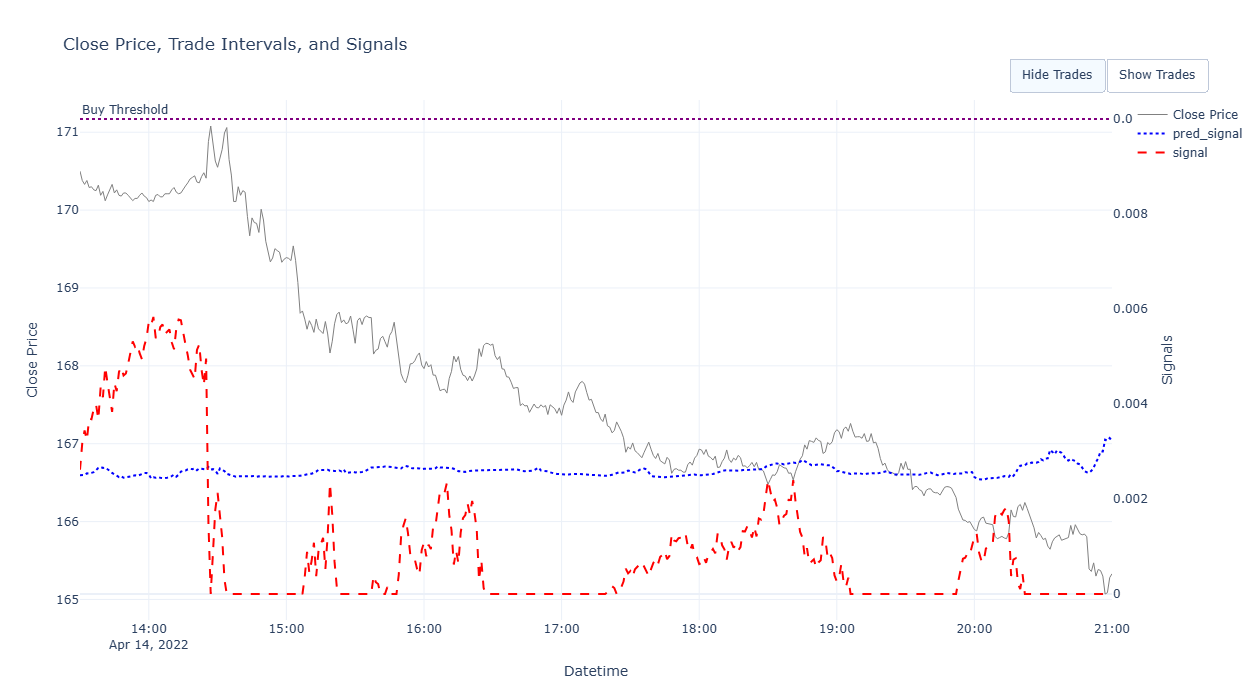


=== Performance for 2022-04-14 00:00:00 ===
Buy & Hold Return ($): -5.321
Strategy Return ($): 0.0
Trades Returns ($): []


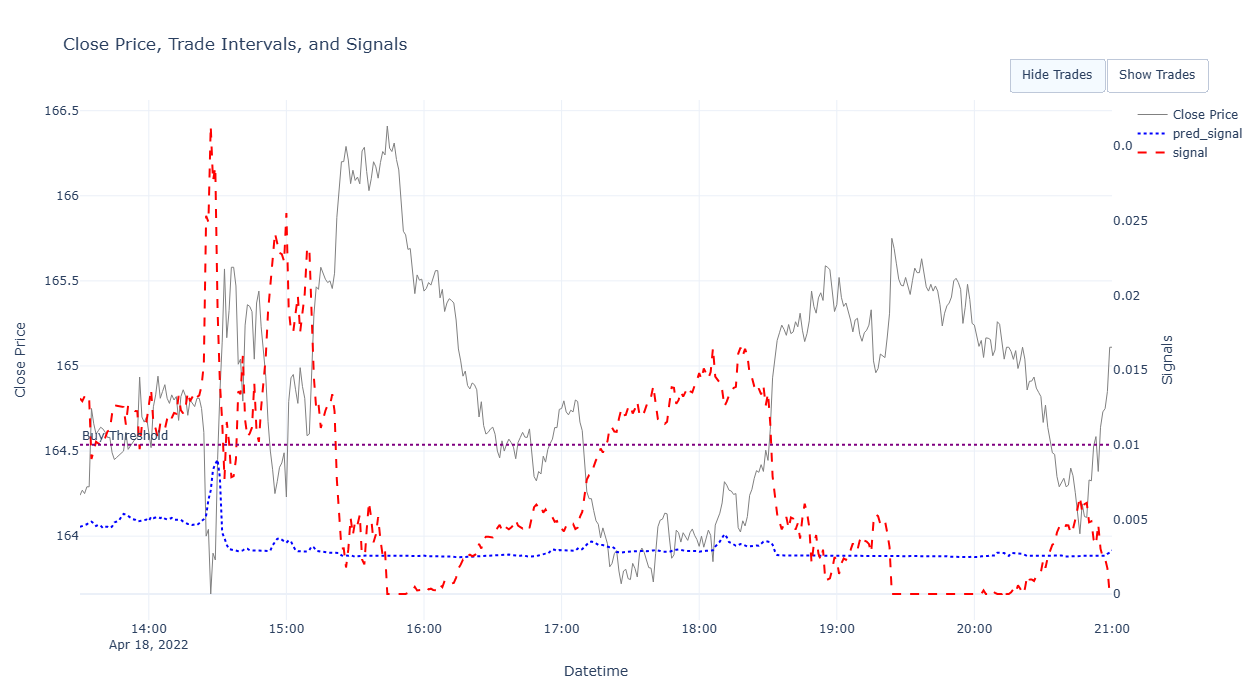


=== Performance for 2022-04-18 00:00:00 ===
Buy & Hold Return ($): 0.561
Strategy Return ($): 0.0
Trades Returns ($): []


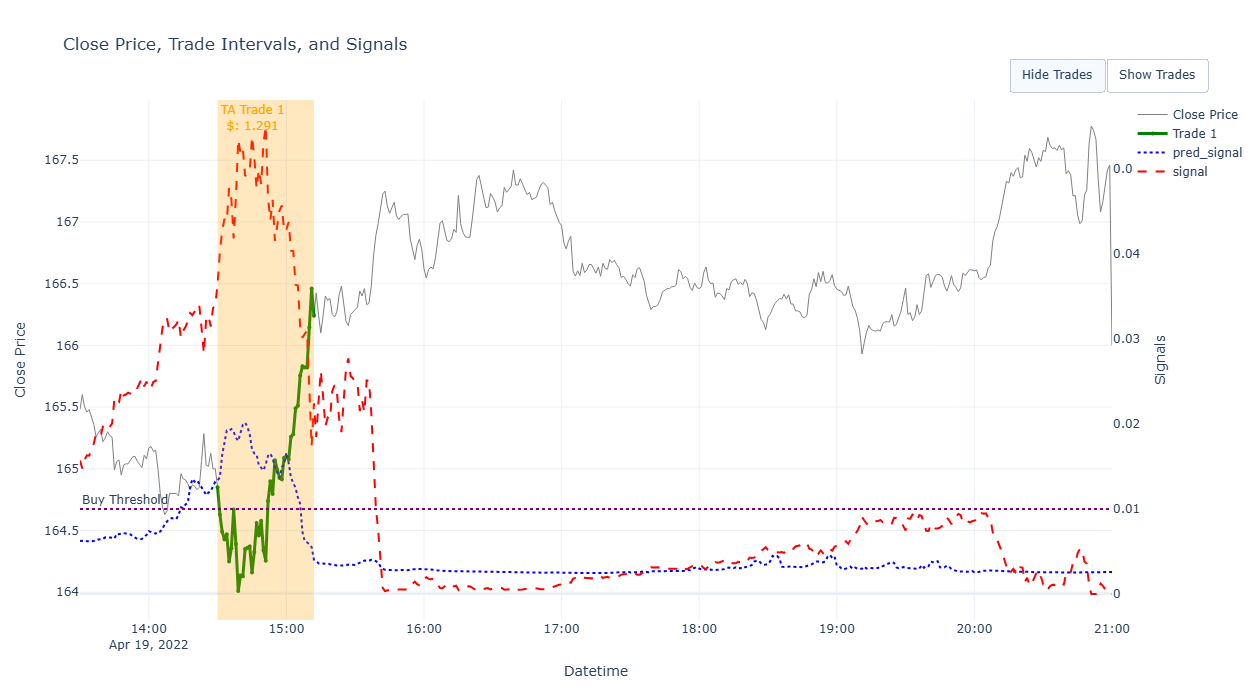


=== Performance for 2022-04-19 00:00:00 ===
Buy & Hold Return ($): 1.051
Strategy Return ($): 1.291
Trades Returns ($): [1.291]


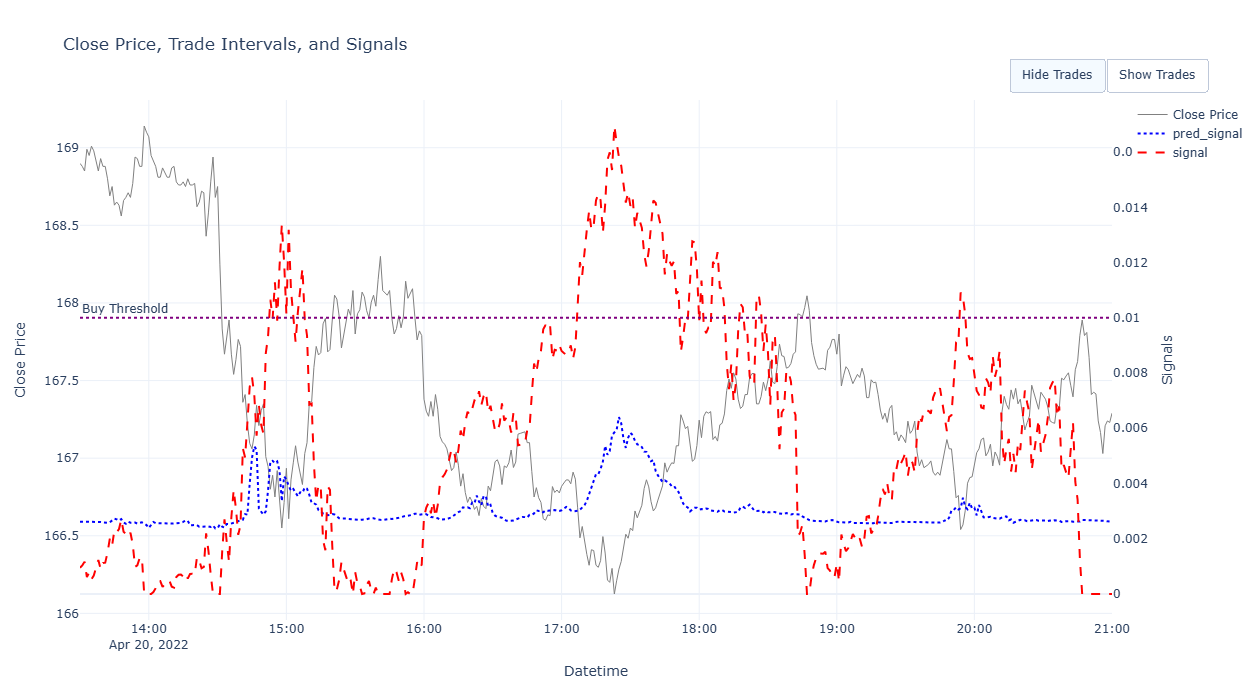


=== Performance for 2022-04-20 00:00:00 ===
Buy & Hold Return ($): -1.561
Strategy Return ($): 0.0
Trades Returns ($): []


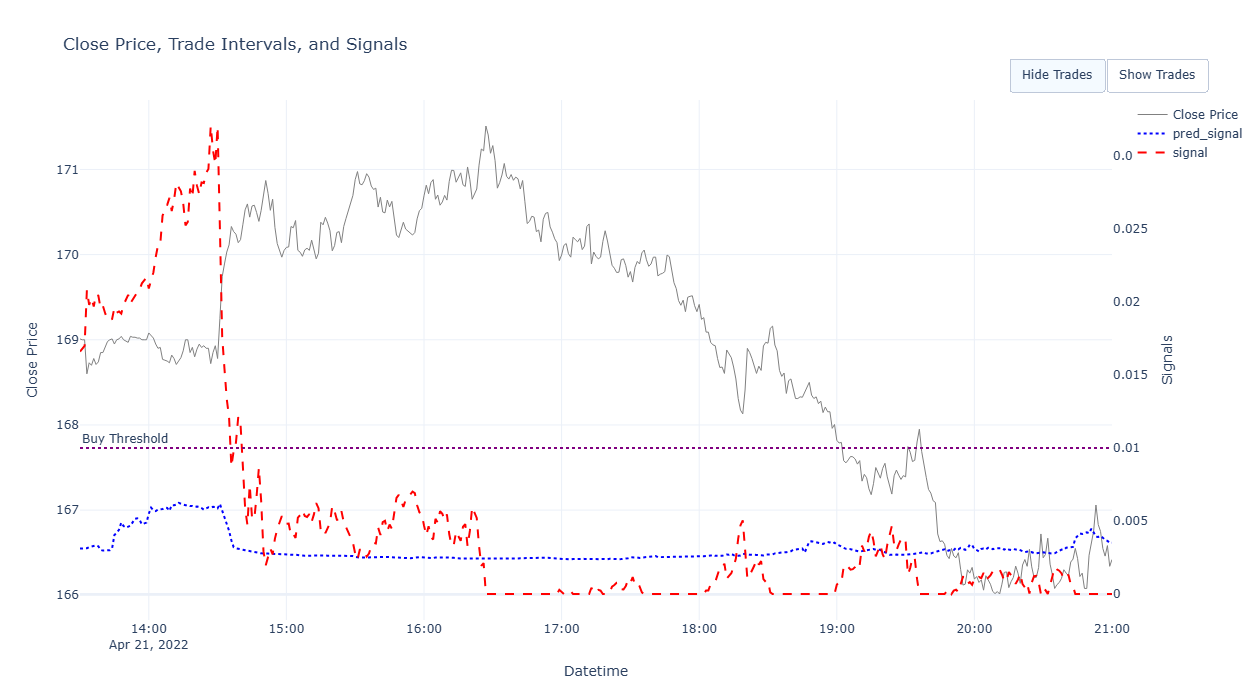


=== Performance for 2022-04-21 00:00:00 ===
Buy & Hold Return ($): -2.46
Strategy Return ($): 0.0
Trades Returns ($): []


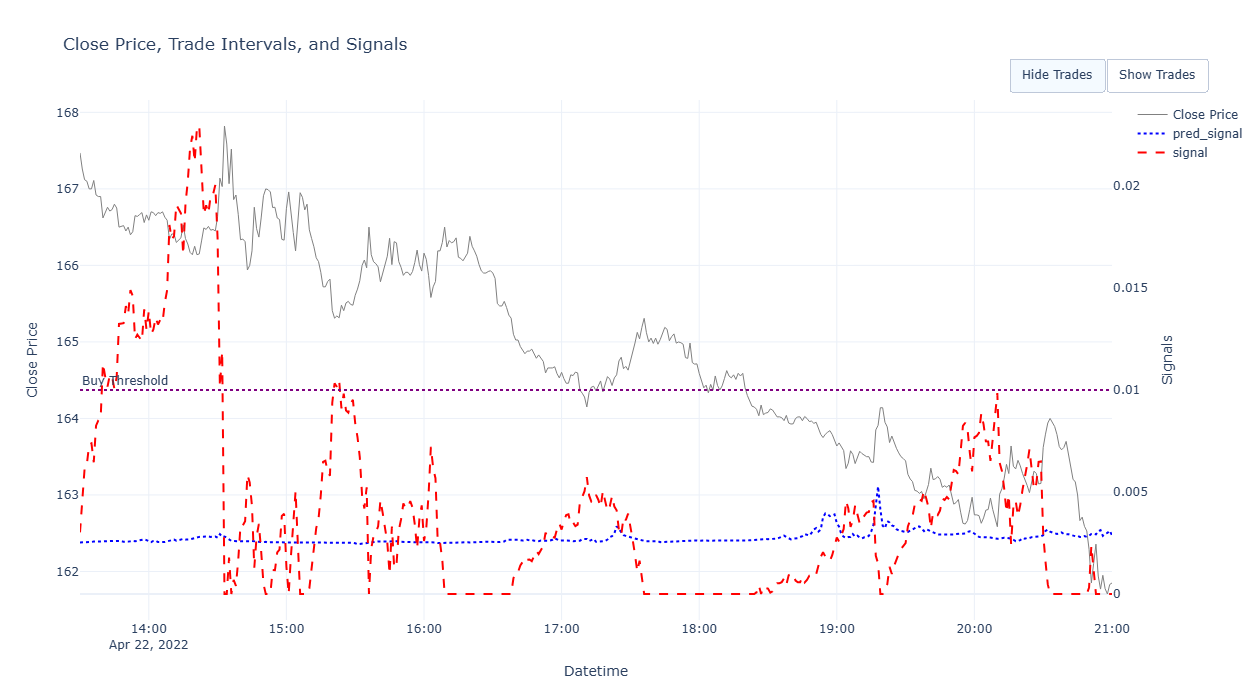


=== Performance for 2022-04-22 00:00:00 ===
Buy & Hold Return ($): -4.889
Strategy Return ($): 0.0
Trades Returns ($): []


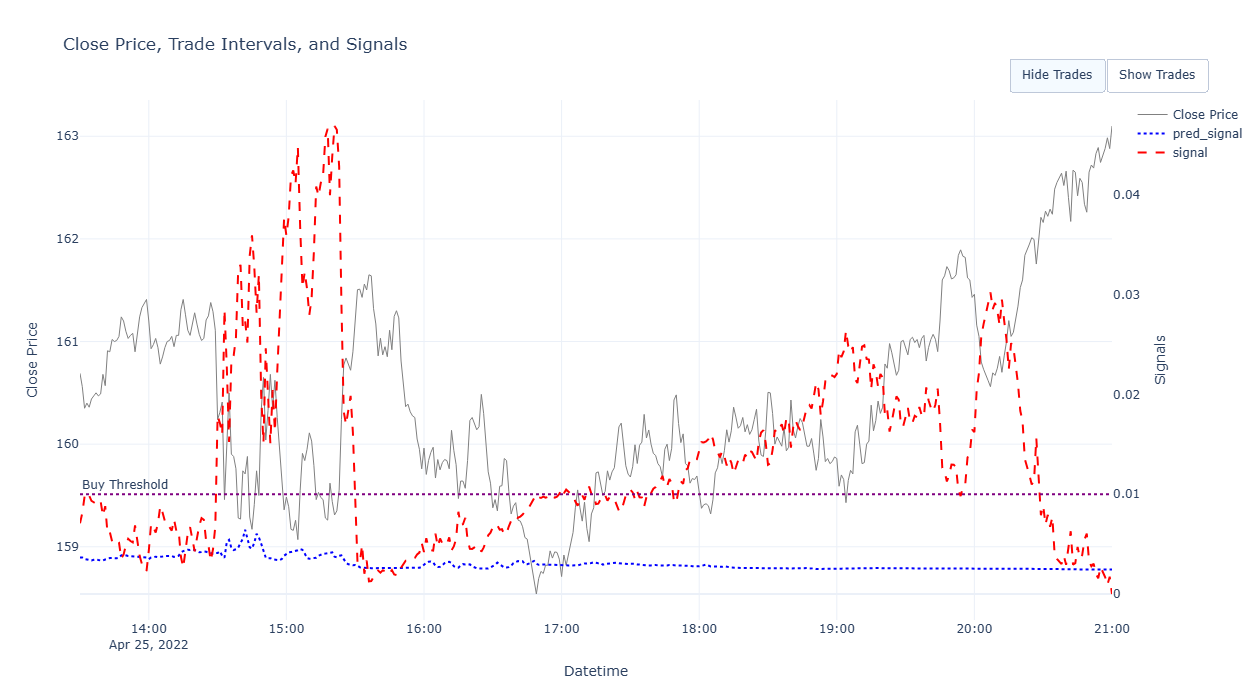


=== Performance for 2022-04-25 00:00:00 ===
Buy & Hold Return ($): 2.763
Strategy Return ($): 0.0
Trades Returns ($): []


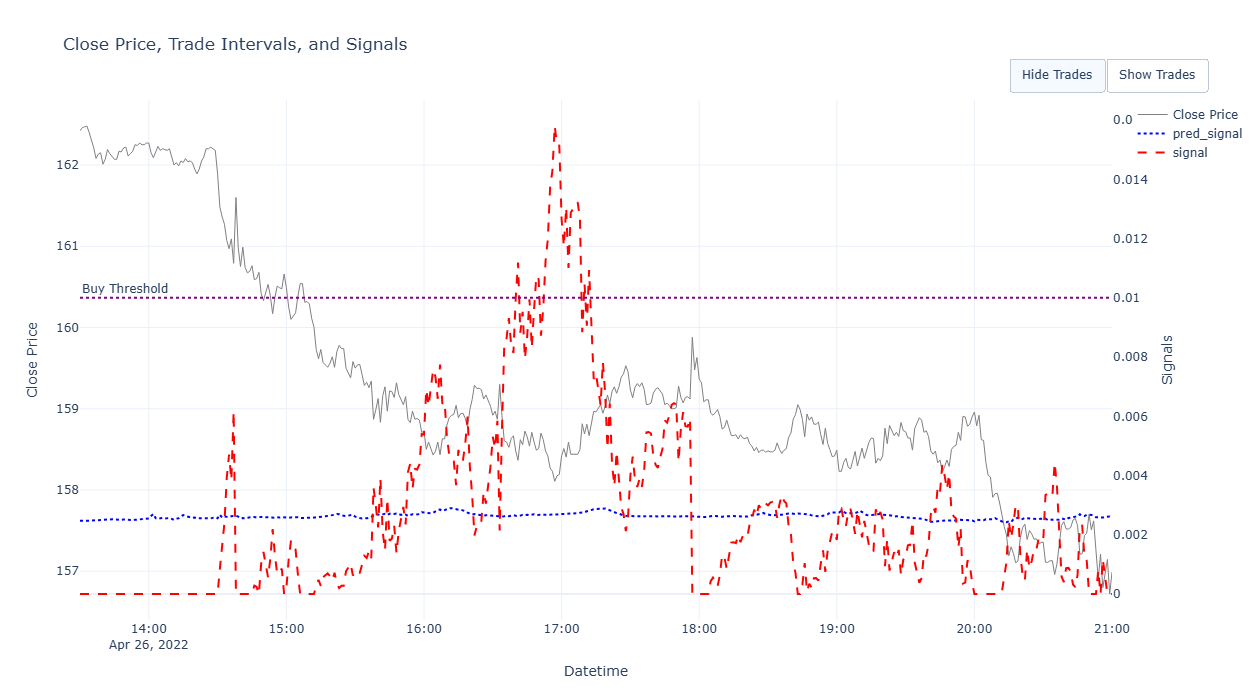


=== Performance for 2022-04-26 00:00:00 ===
Buy & Hold Return ($): -4.996
Strategy Return ($): 0.0
Trades Returns ($): []


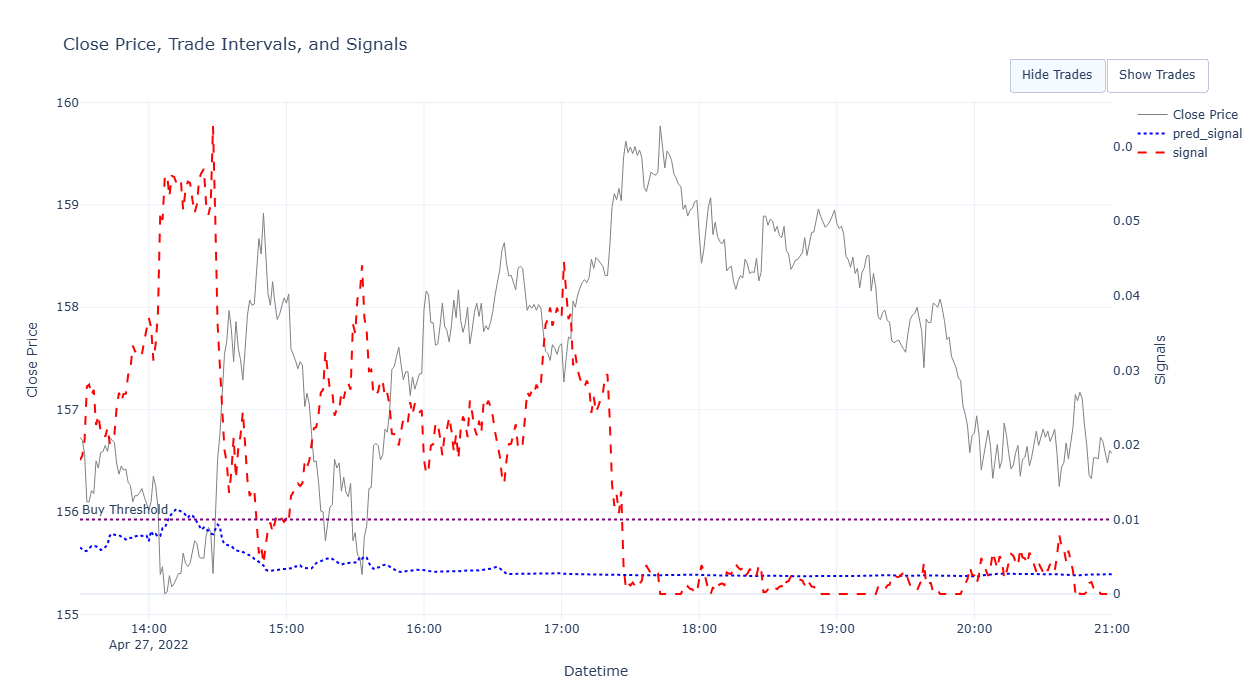


=== Performance for 2022-04-27 00:00:00 ===
Buy & Hold Return ($): -0.04
Strategy Return ($): 0.0
Trades Returns ($): []


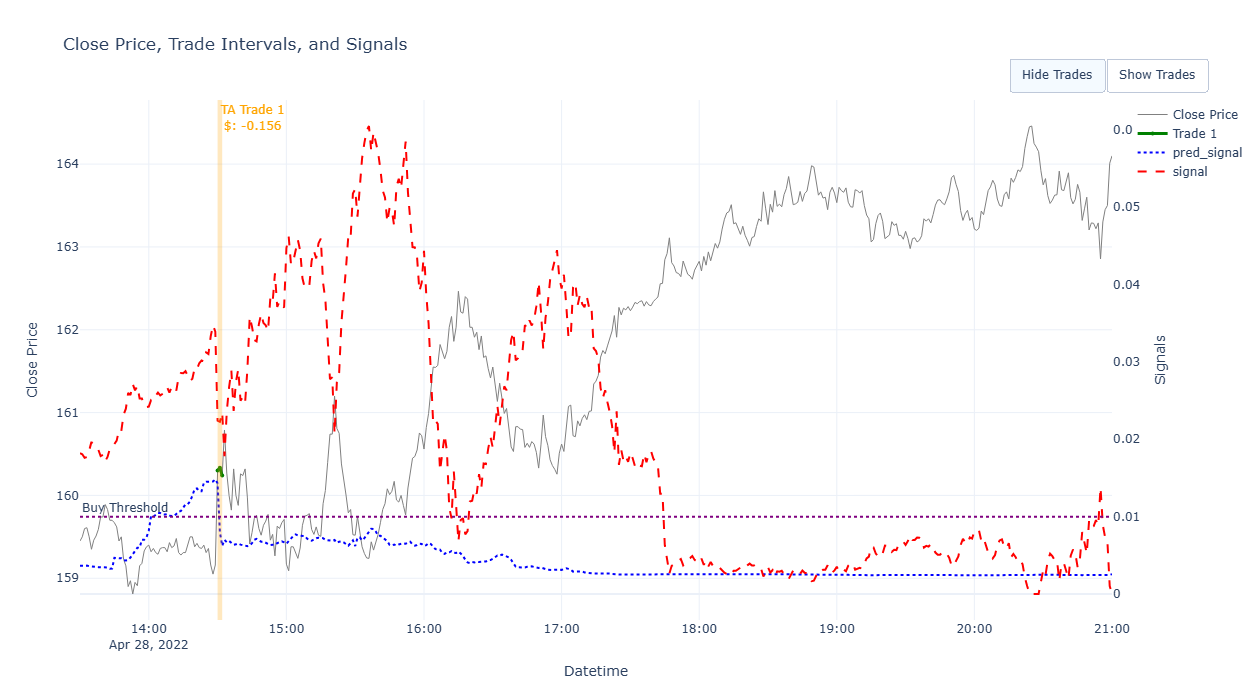


=== Performance for 2022-04-28 00:00:00 ===
Buy & Hold Return ($): 3.703
Strategy Return ($): -0.156
Trades Returns ($): [-0.156]


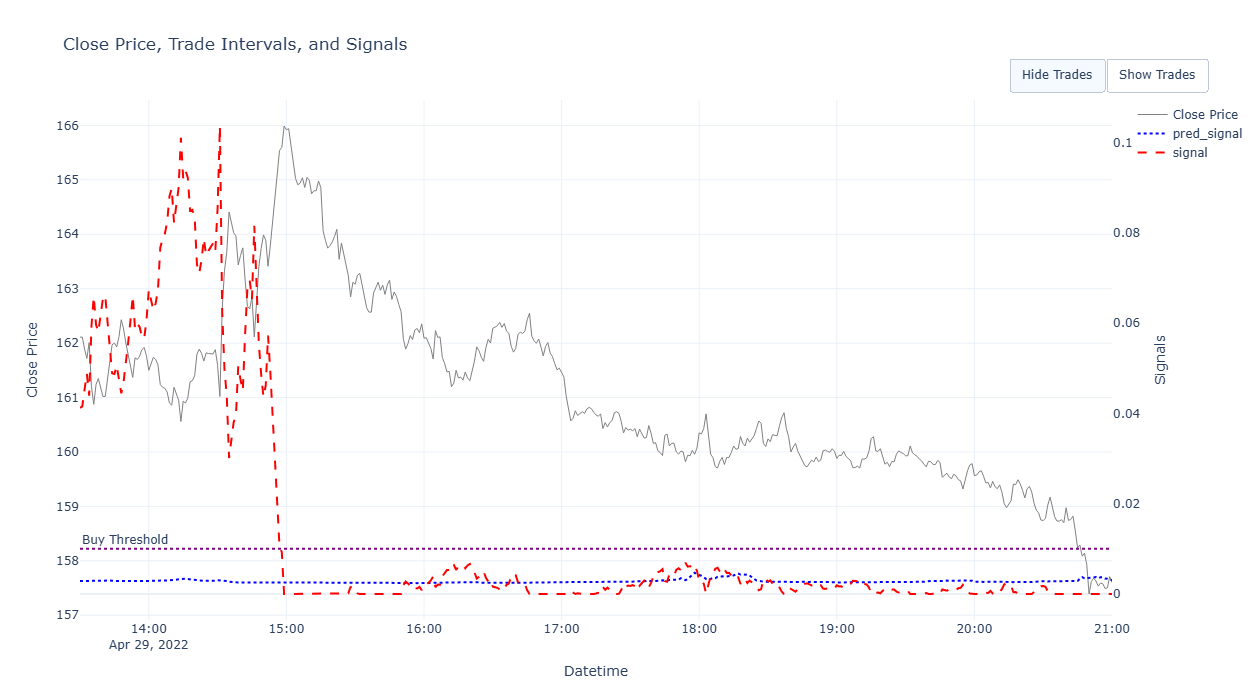


=== Performance for 2022-04-29 00:00:00 ===
Buy & Hold Return ($): -4.086
Strategy Return ($): 0.0
Trades Returns ($): []

Overall Summary (2022-04-01 = 174.5123 → 2022-04-29 = 157.5527)

One-time buy&hold gain: -16.960
Buy & Hold – each day ($): -17.006
Strategy Return ($): 4.078
Trades Count: 5
Strategy return per trade: 0.816
Num. trading days: 20
Strategy return per trading day: 0.204


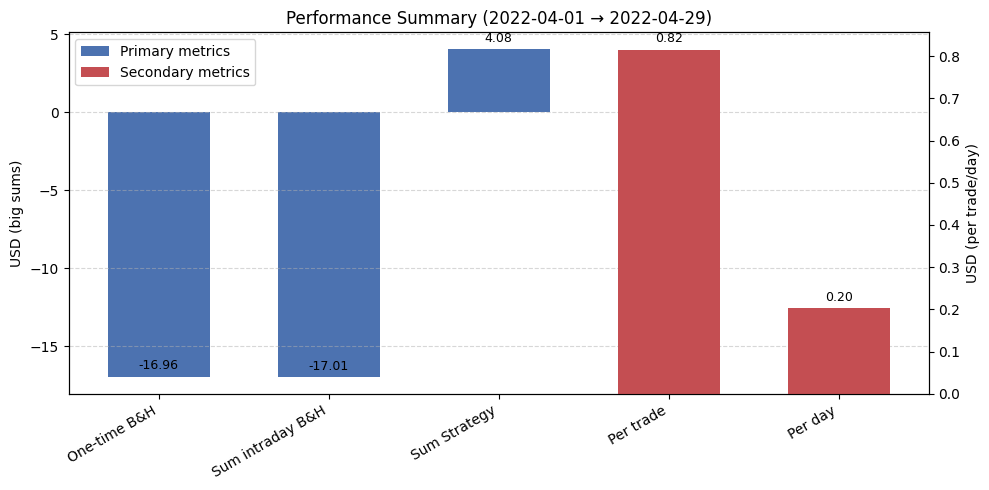


Overall Summary (2022-03-29 = 176.9931 → 2025-06-18 = 196.4810)

One-time buy&hold gain: 19.488
Buy & Hold – each day ($): -57.699
Strategy Return ($): 137.647
Trades Count: 451
Strategy return per trade: 0.305
Num. trading days: 809
Strategy return per trading day: 0.170


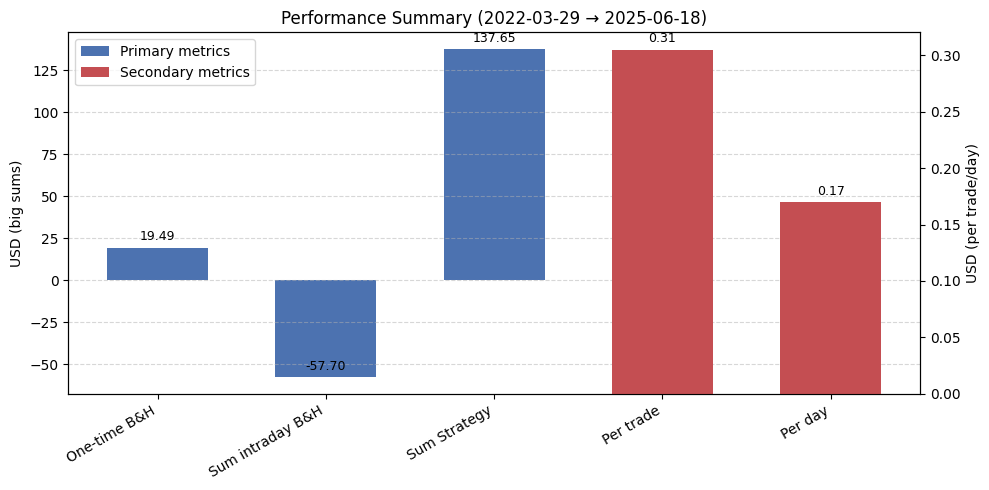

In [20]:
importlib.reload(params)
# month to inspect (YYYY-MM)
date_to_test = params.date_to_check

year, month = map(int, date_to_test.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {date_to_test}")
else:
    print(f"\nPlotting days in {date_to_test}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "pred_signal",
            col_signal2       = "signal",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = pred_threshold,
            performance_stats = perf_stats
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")

# 3) Monthly summary
df_month = df_pred[df_pred.index.to_period("M") == date_to_test]
plots.aggregate_performance(performance_month, df_month)

# 4) Overall summary across ALL days, with date range
plots.aggregate_performance(performance_all, df_pred)